# Imports

In [1]:
import sys
sys.path.insert(1, "..")
from collections import namedtuple
import dill
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import get_full_kernels_in_kernel_expression
from globalParams import options, hyperparameter_limits
import gpytorch
from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from metrics import calculate_AIC as AIC, calculate_BIC as BIC, calculate_laplace as Laplace, NestedSampling as Nested, log_normalized_prior
import numpy as np
import os
import pandas
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch
from scipy.stats import multivariate_normal, spearmanr
import torch

# Helper functions

In [2]:

def prior_distribution(mod):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'AFF':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}
    total_log_prob = torch.tensor(0.0)
    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = None 
    covar_string = gsr(mod.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string = covar_string.replace("RQ", "RQ+RQ")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(mod.named_parameters(), covar_string_list):
        if params == None:
            params = param
        else:
            if len(param.shape)==0:
                params = torch.cat((params,param.unsqueeze(0)))
            elif len(param.shape)==1:
                params = torch.cat((params,param))
            else:
                params = torch.cat((params,param.squeeze(0)))
        debug_param_name_list.append(param_name)
        curr_mu = None
        curr_var = None
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            curr_mu = prior_dict["noise"]["raw_noise"]["mean"]
            curr_var = prior_dict["noise"]["raw_noise"]["std"]
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                curr_mu = prior_dict[cov_str][param_name.split(".")[-1]]["mean"]
                curr_var = prior_dict[cov_str][param_name.split(".")[-1]]["std"]
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                curr_mu = prior_dict[cov_str][param_name.split(".")[-1]]["mean"]
                curr_var = prior_dict[cov_str][param_name.split(".")[-1]]["std"]
                both_PER_params = False
            else:
                try:
                    curr_mu = prior_dict[cov_str][param_name.split(".")[-1]]["mean"]
                    curr_var = prior_dict[cov_str][param_name.split(".")[-1]]["std"]
                except Exception as E:
                    import pdb
                    #pdb.set_trace()
                    prev_cov = cov_str
        theta_mu.append(curr_mu)
        variances_list.append(curr_var)
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    variance = sigma@sigma
    return theta_mu, variance
 
def log_normalized_prior_long(mod, theta_mu=None, sigma=None):
    theta_mu, sigma = prior_distribution(mod) if theta_mu is None or sigma is None else (theta_mu, sigma)
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    params = None
    for (param_name, param) in mod.named_parameters():
        if params == None:
            if len(param.shape)==0:
                params = param.unsqueeze(0)
            elif len(param.shape)==1:
                params = param
            else:
                params = param.squeeze(0)
            #params = param
        else:
            if len(param.shape)==0:
                params = torch.cat((params,param.unsqueeze(0)))
            elif len(param.shape)==1:
                params = torch.cat((params,param))
            else:
                params = torch.cat((params,param.squeeze(0)))

    # for convention reasons I'm diving by the number of datapoints
    log_prob = prior.log_prob(params) / len(*mod.train_inputs)
    return log_prob.squeeze(0)


def log_normalized_prior(mod, theta_mu=None, sigma=None):
    theta_mu, sigma = prior_distribution(mod) if theta_mu is None or sigma is None else (theta_mu, sigma)
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    params = None
    for (param_name, param) in mod.named_parameters():
        if params == None:
            params = param
        else:
            if len(param.shape)==0:
                params = torch.cat((params,param.unsqueeze(0)))
            elif len(param.shape)==1:
                params = torch.cat((params,param))
            else:
                params = torch.cat((params,param.squeeze(0)))
 
    # for convention reasons I'm diving by the number of datapoints
    log_prob = prior.log_prob(params) / len(*mod.train_inputs)
    return log_prob.squeeze(0)

In [3]:
hyperparameter_limits = {"RBFKernel": {"lengthscale": [1e-3,1]},
                         "MaternKernel": {"lengthscale": [1e-3,1]},
                         "LinearKernel": {"variance": [1e-4,1]},
                         "AffineKernel": {"variance": [1e-4,1]},
                         "RQKernel": {"lengthscale": [1e-3,1],
                                      "alpha": [1e-3,1]},
                         "CosineKernel": {"period_length": [1e-3,3]},
                         "PeriodicKernel": {"lengthscale": [1e-3,1],
                                            "period_length": [1e-3,3]},
                         "ScaleKernel": {"outputscale": [1e-3,10]},
                         "Noise": [1e-2,1e-1],
                         "MyPeriodKernel":{"period_length": [1e-3,3]}}

def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value


def fixed_reinit(model, parameters):
    for i, (param, value) in enumerate(zip(model.parameters(), parameters)):
        param.data = torch.full_like(param.data, value)


# Define the training loop
def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    MAP = kwargs.get("MAP", True)
    double_precision = kwargs.get("double_precision", False)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    opts.globalAD = True
    opts.double_precision = double_precision
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        try:
            # TODO PyGRANSO dying is a severe problem. as it literally exits the program instead of raising an error
            #import pdb;pdb.set_trace()
            loss = -mll(output, train_y)
        except Exception as E:
            print("LOG ERROR: Severe PyGRANSO issue. Loss is inf+0")
            loss = torch.tensor(np.inf, requires_grad=True) + torch.tensor(0)
        if MAP:
            # log_normalized_prior is in metrics.py 
            log_p = log_normalized_prior(model)
            loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = int(2)
    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        # TODO write a try/except block around here and watch the stacktrace in case it explodes
        try:
            soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
            print(f"Restart {restart} : trained parameters: {list(model.named_parameters())}")
        except Exception as e:
            print(e)
            import pdb
            pdb.set_trace()
            # TODO You want the stacktrace here!
            pass

        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)
    print(f"----")
    print(f"Final best parameters: {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
    print(f"----")

    loss = -mll(model(train_x), train_y)
    if MAP:
        log_p = log_normalized_prior(model)
        loss -= log_p

    #print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    #print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    #print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood


def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y


# Find all points inside the confidence ellipse
def percentage_inside_ellipse(mu, K, points, sigma_level=2):
    L = np.linalg.cholesky(K)
    threshold = sigma_level ** 2
    count = 0
    for point in points:
        res = np.array(point - mu) @ np.linalg.inv(L)
        if res @ res <= threshold:
            count += 1
    return count / len(points)


def log_dill(data, filename):
    with open(filename, 'wb') as f:
        dill.dump(data, f)

# Plotting functions

### 1D

In [4]:

def plot_data(X, Y, return_figure=False, title_add="", figure=None, ax=None, display_figure=True):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(X.numpy(), Y.numpy(), 'k.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f"Data {title_add}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax

def plot_model(model, likelihood, X, Y, display_figure=True, return_figure=False, figure=None,
               ax=None, loss_val=None, loss_type = None):
    interval_length = torch.max(X) - torch.min(X)
    shift = interval_length * options["plotting"]["border_ratio"]
    test_x = torch.linspace(torch.min(
        X) - shift, torch.max(X) + shift, options["plotting"]["sample_points"])

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        if not (figure and ax):
            figure, ax = plt.subplots(1, 1, figsize=(8, 6))

        lower, upper = observed_pred.confidence_region()
        ax.plot(X.numpy(), Y.numpy(), 'k.', zorder=2)
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), color="b", zorder=3)
        amount_of_gradient_steps = 30
        alpha_min = 0.05
        alpha_max = 0.8
        alpha = (alpha_max-alpha_min)/amount_of_gradient_steps
        c = ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(
        ), alpha=alpha+alpha_min, zorder=1).get_facecolor()

        for i in range(1, amount_of_gradient_steps):
            ax.fill_between(test_x.numpy(), (lower+(i/amount_of_gradient_steps)*(upper-lower)).numpy(),
                            (upper-(i/amount_of_gradient_steps)*(upper-lower)).numpy(), alpha=alpha, color=c, zorder=1)
        if options["plotting"]["legend"]:
            ax.plot([], [], 'k.', label="Data")
            ax.plot([], [], 'b', label="Mean")
            ax.plot([], [], color=c, alpha=1.0, label="Confidence")
            ax.legend(loc="upper left")
        ax.set_xlabel("Normalized Input")
        ax.set_ylabel("Normalized Output")
        ax.set_title(f"{loss_type}: {loss_val:.2f}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return figure, ax


# Stolen from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(mu, K, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    cov = K
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0] 

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### 2D

In [5]:
def plot_3d_data(samples, xx, yy, return_figure=False, fig=None, ax=None, display_figure=True):
    """
    Similar to plot_3d_gp_samples, but color-codes each (xx, yy) point in 3D.
    'samples' can be a single 1D tensor or multiple samples in a 2D tensor.
    """
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if samples.ndim == 1:
        samples = samples.unsqueeze(0)

    for sample in samples:
        z_vals = sample.reshape(xx.shape)
        ax.scatter(xx.numpy(), yy.numpy(), z_vals.numpy(),
                   c=z_vals.numpy(), cmap='viridis', alpha=0.8)

    ax.set_title('3D Color-Coded Points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output Value')
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax

def plot_3d_gp_samples(samples, xx, yy, return_figure=False, fig=None, ax=None, display_figure=True):
    """
    Visualize multiple samples drawn from a 2D-input (xx, yy) -> 1D-output GP in 3D.
    Each sample in 'samples' should be a 1D tensor that can be reshaped to match xx, yy.
    """
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if samples.ndim == 1:
        samples = samples.unsqueeze(0)
    for i, sample in enumerate(samples):
        z_vals = sample.reshape(xx.shape)
        ax.plot_surface(xx.numpy(), yy.numpy(), z_vals.numpy(), alpha=0.4)

    ax.set_title('GP Samples in 3D')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax

def plot_3d_gp(model, likelihood, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,
                resolution=50, return_figure=False, fig=None, ax=None, display_figure=True):

    model.eval()
    likelihood.eval()

    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    xx, yy = torch.meshgrid(x_vals, y_vals)
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds = likelihood(model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)

    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

    # Plot mean surface
    ax.plot_surface(xx.numpy(), yy.numpy(), mean.numpy(), cmap='viridis', alpha=0.8)

    # Plot lower and upper surfaces
    ax.plot_surface(xx.numpy(), yy.numpy(), lower.numpy(), color='gray', alpha=0.2)
    ax.plot_surface(xx.numpy(), yy.numpy(), upper.numpy(), color='gray', alpha=0.2)

    ax.set_title('2D GP in 3D')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Mean and Variance Range')

    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax


# Definitions

In [6]:
DatasetInfo = namedtuple('DatasetInfo', ['name', 'path', 'dimension', 'description'])
datasets_1d = {
    "alternating" : DatasetInfo('alternating', 'datasets/alternating.csv', 1, 'Alternates between high and low'),
    "broaden" : DatasetInfo('broaden', 'datasets/broaden.csv', 1, 'Data with increasing variance'),
    "large gap" : DatasetInfo('large gap', 'datasets/large_gap.csv', 1, 'Contains large gap between X values'),
    "linear outlier" : DatasetInfo('linear outlier', 'datasets/linear_outlier.csv', 1, 'Linear data with outlier in last entry'),
    "parabola" : DatasetInfo('parabola', 'datasets/parabola.csv', 1, 'Parabola'),
    "periodic linear" : DatasetInfo('periodic linear', 'datasets/periodic_linear.csv', 1, 'Periodic data that changes to becoming purely linear'),
    "periodic" : DatasetInfo('periodic', 'datasets/periodic.csv', 1, 'Periodic data'),
    "v_lines" : DatasetInfo('v_lines', 'datasets/v_lines.csv', 1, 'Vertical lines'),
}

## GP definition

In [7]:


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()

        if kernel_text == "C*C*SE":
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))
        elif kernel_text == "SE":
            self.covar_module = gpytorch.kernels.RBFKernel()
        elif kernel_text == "C*SE":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel_text == "LIN":
            self.covar_module = gpytorch.kernels.LinearKernel()
        elif kernel_text == "LIN*SE":
            self.covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.RBFKernel()
        elif kernel_text == "LIN*PER":
            self.covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "SE+SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "RQ":
            self.covar_module = gpytorch.kernels.RQKernel()
        elif kernel_text == "PER":
            self.covar_module = gpytorch.kernels.PeriodicKernel()
        #elif kernel_text == "PER+SE":
        #    if weights is None:
        #        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #    else:
        #        self.covar_module = weights[0]*gpytorch.kernels.PeriodicKernel() + weights[1]*gpytorch.kernels.RBFKernel()
        elif kernel_text == "PER*SE":
            self.covar_module = gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
        #elif kernel_text == "PER*LIN":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        elif kernel_text == "MAT32":
            self.covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
        elif kernel_text == "MAT32+MAT52":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.MaternKernel()
        elif kernel_text == "MAT32*PER":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT32+PER":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT32*SE":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) * gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT32+SE":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT52":
            self.covar_module = gpytorch.kernels.MaternKernel()
        elif kernel_text == "MAT52*PER":
            self.covar_module =  gpytorch.kernels.MaternKernel() * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT52+SE":
            self.covar_module =  gpytorch.kernels.MaternKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "SE*SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() * gpytorch.kernels.RBFKernel()
        elif kernel_text == "(SE+RQ)*PER":
            self.covar_module =  (gpytorch.kernels.RBFKernel() + gpytorch.kernels.RQKernel()) * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "SE+SE+SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT32+(MAT52*PER)":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + (gpytorch.kernels.MaternKernel() * gpytorch.kernels.PeriodicKernel())

        #elif kernel_text == "RQ*PER":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #elif kernel_text == "RQ*MAT32":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        #elif kernel_text == "RQ*SE":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class ExactMIGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactMIGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        if kernel_text == "[RBF; RBF]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.RBFKernel(active_dims=1), num_dims=2)
        elif kernel_text == "[RBF; LIN]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.LinearKernel(active_dims=1), num_dims=2)
        elif kernel_text == "[LIN; RBF]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.LinearKernel(active_dims=0) + gpytorch.kernels.RBFKernel(active_dims=1), num_dims=2)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Various 1D and 2D datasets 

In [8]:
possible_kenels = ["SE",
    "LIN",
    "LIN*SE",
    "LIN*PER",
    "SE+SE",
    "RQ",
    "PER",
    "PER*SE",
    "MAT32",
    "MAT32+MAT52",
    "MAT32*PER",
    "MAT32+PER",
    "MAT32*SE",
    "MAT32+SE",
    "MAT52",
    "MAT52*PER",
    "MAT52+SE",
    "SE*SE",
    "(SE+RQ)*PER",
    "SE+SE+SE",
    "MAT32+(MAT52*PER)"]

possible_datasets = [
   "alternating",
   "broaden",
   "large gap",
   "linear outlier",
   "parabola",
   "periodic linear",
   "periodic",
   "v_lines"
]

kernel_name = "C*SE"
dataset_name = "linear"
dataset_addendum = "51 points"
data_normalization = True
data_norm_y = False 
levels = [1e+3]#, 1e+4, 1e+5]

log_path = f"logs/{'x-normalized' if data_normalization else ''}_{dataset_name}_{dataset_addendum}/{kernel_name}"
if not os.path.exists(log_path):
    os.makedirs(log_path)

## 1D data

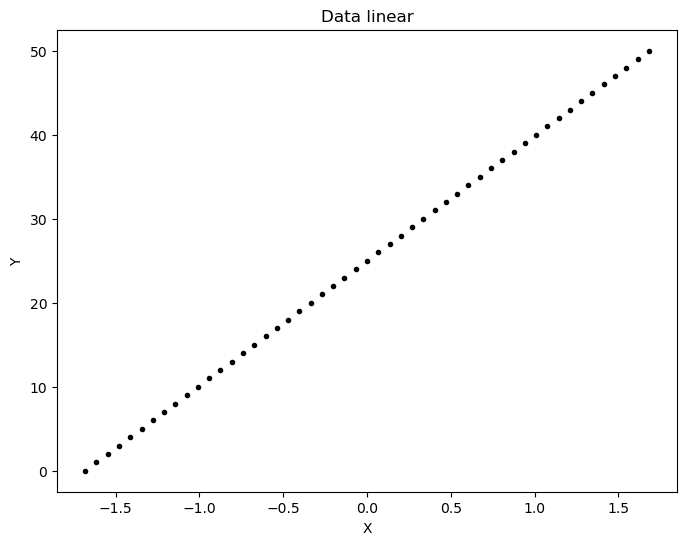

In [9]:


# Load the dataset
if dataset_name in datasets_1d:
    df = pandas.read_csv(datasets_1d[dataset_name].path, header=None)
    train_x = torch.tensor(df[0], dtype=torch.float32)
    train_y = torch.tensor(df[1], dtype=torch.float32)

elif dataset_name == "linear":
    train_x = torch.linspace(0, int(dataset_addendum.split(" ")[0])-1, int(dataset_addendum.split(" ")[0]))
    train_y = train_x.clone()
    #train_y[-1] = 0 


# Z score normalization
if data_normalization:
    train_x = (train_x - train_x.mean()) / train_x.std()
    if data_norm_y:
        train_y = (train_y - train_y.mean()) / train_y.std()

fig, ax = plot_data(train_x, train_y, title_add=dataset_name, return_figure=True)
fig.savefig(f"{log_path}/data.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/data.pgf", bbox_inches='tight')

In [10]:
len(train_x)

51

In [11]:
## Define the GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
model_MAP = ExactGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)

In [12]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [13]:
## Train the GPs
model.train()
likelihood.train()
mll_loss, model, likelihood = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False)
mll_opt_params = [p.item() for p in model.parameters() if p.requires_grad]

/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


Restart 0 : trained parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-72.9569], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(78.2877, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[1.6245]], requires_grad=True))]
Restart 1 : trained parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-72.9569], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(78.2877, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[1.6245]], requires_grad=True))]
----
Final best parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-72.9569], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(78.2877, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[1.6245]], requires_grad=True))] w.

In [14]:
model_MAP.train()
likelihood_MAP.train()
map_loss, model_MAP, likelihood_MAP = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True)
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

Restart 0 : trained parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.4005], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(21.1213, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.6724]], requires_grad=True))]
Restart 1 : trained parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.4005], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(21.1213, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.6724]], requires_grad=True))]
----
Final best parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.4005], requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(21.1213, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.6724]], requires_grad=True))] w.

In [15]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


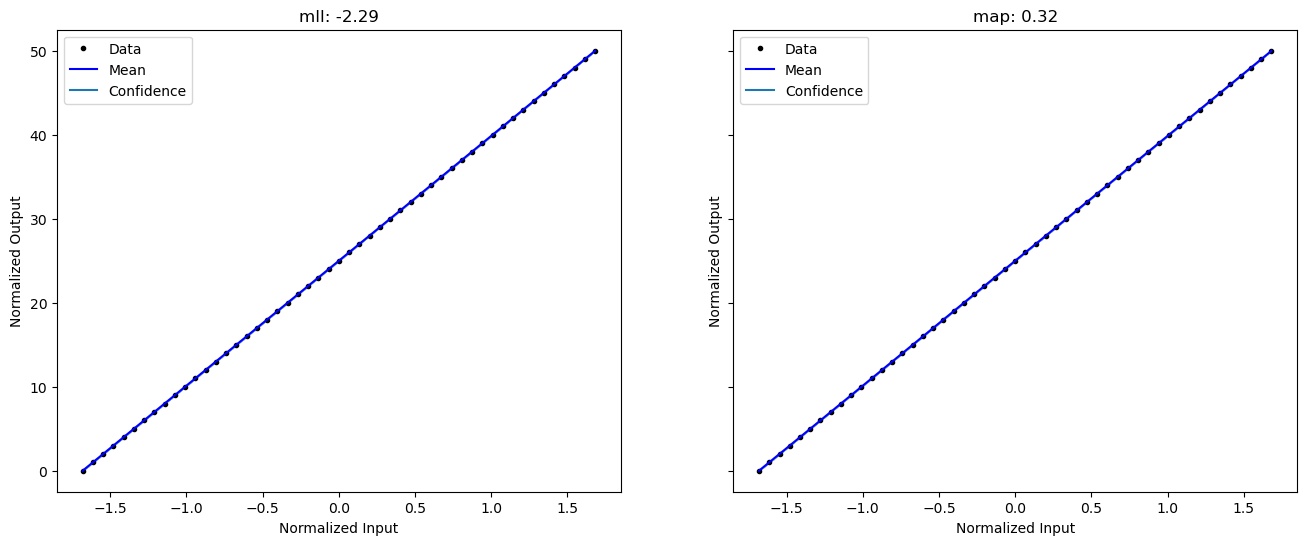

In [16]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax = axs[0]
ax_MAP = axs[1]
plot_model(model, likelihood, train_x, train_y, return_figure=False, figure=fig, ax=ax, loss_val=mll_loss.item(), loss_type="mll", display_figure=False)
plot_model(model_MAP, likelihood_MAP, train_x, train_y, return_figure=False, figure=fig, ax=ax_MAP, loss_val=map_loss.item(), loss_type="map")
fig.savefig(f"{log_path}/posterior.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/posterior.pgf", bbox_inches='tight')

In [17]:
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [18]:
unscaled_MLL = -mll_loss*len(*model.train_inputs)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

## Calculate the metrics
AIC_val, AIC_logs = AIC(unscaled_MLL, num_params)
BIC_val, BIC_logs = BIC(unscaled_MLL, num_params, torch.tensor(len(train_x)))
AIC_MAP_val, AIC_MAP_logs = AIC(unscaled_MAP, num_params)
BIC_MAP_val, BIC_MAP_logs = BIC(unscaled_MAP, num_params, torch.tensor(len(train_x)))
Lap0_val, Lap0_logs = Laplace(model_MAP, unscaled_MAP, param_punish_term=0)
LapAIC_val, LapAIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), param_punish_term=-1)
LapBIC_val, LapBIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), param_punish_term="BIC")

/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


In [19]:
Lap0_logs

{'MAP': tensor(16.4419, grad_fn=<NegBackward0>),
 'punish term': tensor(-1.9654, dtype=torch.float64),
 'laplace without replacement': tensor(-16.1886, dtype=torch.float64, grad_fn=<SubBackward0>),
 'correction term': 0,
 'num_replaced': tensor(2),
 'parameter list': ['likelihood.noise_covar.raw_noise',
  'covar_module.raw_outputscale',
  'covar_module.base_kernel.raw_lengthscale'],
 'Jacobian': (tensor([0.0140], grad_fn=<AddBackward0>),
  tensor(0.0317, grad_fn=<AddBackward0>),
  tensor([[-0.6270]], grad_fn=<AddBackward0>)),
 'parameter values': tensor([[-12.4005],
         [ 21.1213],
         [  0.6724]]),
 'corrected Hessian': tensor([[ 6.2835e+00, -9.8041e-04,  2.9806e-01],
         [-9.8041e-04,  6.2866e+00, -1.0321e+00],
         [ 2.9806e-01, -1.0321e+00,  3.2006e+02]], dtype=torch.float64),
 'diag(constructed eigvals)': tensor([  6.2832,   6.2832, 320.0629], dtype=torch.float64),
 'original symmetrized Hessian': tensor([[ 7.5731e-01,  4.5835e-03,  3.0333e-01],
         [ 4.583

In [20]:
LapAIC_logs

{'MAP': tensor(16.4419, grad_fn=<NegBackward0>),
 'punish term': tensor(-3.9654, dtype=torch.float64),
 'laplace without replacement': tensor(-16.1886, dtype=torch.float64, grad_fn=<SubBackward0>),
 'correction term': -1,
 'num_replaced': tensor(2),
 'parameter list': ['likelihood.noise_covar.raw_noise',
  'covar_module.raw_outputscale',
  'covar_module.base_kernel.raw_lengthscale'],
 'Jacobian': (tensor([0.0140], grad_fn=<AddBackward0>),
  tensor(0.0317, grad_fn=<AddBackward0>),
  tensor([[-0.6270]], grad_fn=<AddBackward0>)),
 'parameter values': tensor([[-12.4005],
         [ 21.1213],
         [  0.6724]]),
 'corrected Hessian': tensor([[ 4.6427e+01, -8.5498e-04,  2.5993e-01],
         [-8.5498e-04,  4.6430e+01, -9.0007e-01],
         [ 2.5993e-01, -9.0007e-01,  3.2006e+02]], dtype=torch.float64),
 'diag(constructed eigvals)': tensor([ 46.4268,  46.4268, 320.0629], dtype=torch.float64),
 'original symmetrized Hessian': tensor([[ 7.5731e-01,  4.5835e-03,  3.0333e-01],
         [ 4.58

In [21]:
LapBIC_logs

{'MAP': tensor(16.4419, grad_fn=<NegBackward0>),
 'punish term': tensor(-5.8979, dtype=torch.float64),
 'laplace without replacement': tensor(-16.1886, dtype=torch.float64, grad_fn=<SubBackward0>),
 'correction term': tensor(-1.9659, dtype=torch.float64),
 'num_replaced': tensor(3),
 'parameter list': ['likelihood.noise_covar.raw_noise',
  'covar_module.raw_outputscale',
  'covar_module.base_kernel.raw_lengthscale'],
 'Jacobian': (tensor([0.0140], grad_fn=<AddBackward0>),
  tensor(0.0317, grad_fn=<AddBackward0>),
  tensor([[-0.6270]], grad_fn=<AddBackward0>)),
 'parameter values': tensor([[-12.4005],
         [ 21.1213],
         [  0.6724]]),
 'corrected Hessian': tensor([[ 3.2044e+02,  1.5438e-15, -2.7320e-15],
         [ 1.5439e-15,  3.2044e+02,  3.9474e-14],
         [-2.6868e-15,  3.9676e-14,  3.2044e+02]], dtype=torch.float64),
 'diag(constructed eigvals)': tensor([320.4425, 320.4425, 320.4425], dtype=torch.float64),
 'original symmetrized Hessian': tensor([[ 7.5731e-01,  4.5835e

In [22]:
model_evidences = list()
model_evidence_logs = list()

In [23]:
maxcall = 1e+1
if maxcall in levels:
    print(maxcall)
    Nested_val_e1, Nested_logs_e1 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e1)
    model_evidence_logs.append(Nested_logs_e1)

In [24]:
maxcall = 1e+2
if maxcall in levels:
    print(maxcall)
    Nested_val_e2, Nested_logs_e2 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e2)
    model_evidence_logs.append(Nested_logs_e2)

In [25]:
maxcall = 1e+3
if maxcall in levels:
    print(maxcall)
    Nested_val_e3, Nested_logs_e3 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e3)
    model_evidence_logs.append(Nested_logs_e3)

1000.0
Random seed: 453001


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/sampler.py:761: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'


In [26]:
maxcall = 1e+4
if maxcall in levels:
    print(maxcall)
    Nested_val_e4, Nested_logs_e4 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e4)
    model_evidence_logs.append(Nested_logs_e4)

In [27]:
maxcall = 1e+5
if maxcall in levels:
    print(maxcall)
    Nested_val_e5, Nested_logs_e5 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e5)
    model_evidence_logs.append(Nested_logs_e5)

In [28]:
for mod_log in model_evidence_logs:
    with open(f"{mod_log['res file']}", "rb") as f:
        res = dill.load(f)
    print(f"Num calls: {sum(res.ncall)}")
    print(f"logz Error: {res["logzerr"][-1]}")

Num calls: 1504
logz Error: 2.351385700730902


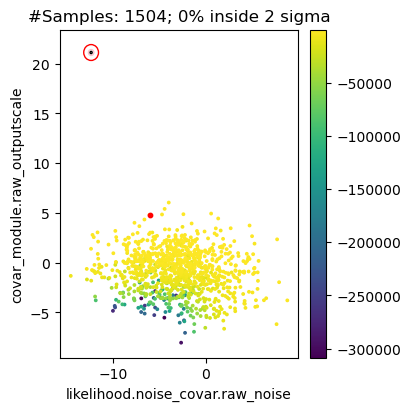

In [29]:
# Make a "loop" out of the Nested levels to compare them to each other
f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    with open(f"{model_evidence_log['res file']}", "rb") as f:
        res = dill.load(f)
    
    # Plot the actual figure
    param_names = [l[0] for l in list(model.named_parameters())]
    xdim = 0
    ydim = 1

    # Find the best value and the corresponding hyperparameters
    best_idx = np.argmax(res.logl)
    best_hyperparameters = res.samples[best_idx]

    # Do an outlier cleanup on res.logz
    logz_mean = np.mean(res.logz) # model_evidence_log["parameter statistics"]["mu"] #
    logz_std = np.std(res.logz)   # model_evidence_log["parameter statistics"]["std"]#
    std_filter = -1e-0
    filter_type = "max" # "mean", "max"
    if filter_type == "max":
        mask = res.logz >= max(res.logz)+std_filter*logz_std
    elif filter_type == "mean":
        mask = res.logz >= logz_mean+std_filter*logz_std
    #mask = res.logz == res.logz



    likelihood_surface_scatter = ax.scatter(res.samples[:,xdim][mask], res.samples[:,ydim][mask], c=res.logz[mask], s=3)
    # Best found hyperparameters
    ax.scatter(best_hyperparameters[xdim], best_hyperparameters[ydim], c="r", s=10)

    plot_mll_opt = False
    if plot_mll_opt:
        ax.scatter(mll_opt_params[xdim], mll_opt_params[ydim], c="black", s=10)
        # Add a small text beside the point saying "MLL"
        ax.text(mll_opt_params[xdim], mll_opt_params[ydim], "MLL", fontsize=12, color="black", verticalalignment='center', horizontalalignment='right')
    #ax.scatter(map_opt_params[xdim], map_opt_params[ydim], c="b", s=10)
    ## Add a small text beside the point saying "MAP"
    #ax.text(map_opt_params[xdim], map_opt_params[ydim], "MAP", fontsize=12, color="b", verticalalignment='center', horizontalalignment='right')
    
    coverages = list()
    # Plot the Laplace levels
    for lap_log, lap_color in zip([Lap0_logs, LapAIC_logs, LapBIC_logs], ["r", "pink", "black"]):
        lap_param_mu = lap_log["parameter values"]
        # Wait a minute, isn't the Hessian the inverse of the covariance matrix? Yes, see Murphy PML 1 eq. (7.228)
        lap_param_cov_matr = torch.linalg.inv(lap_log["corrected Hessian"])
        # Calculate the amount of samples that are covered by the 1 sigma and 2 sigma interval based on the lap_mu and lap_cov values
        lap_2_sig_coverage = percentage_inside_ellipse(lap_param_mu.flatten().numpy(), lap_param_cov_matr.numpy(), res.samples[mask])
        coverages.append(lap_2_sig_coverage)
        #ax.scatter(lap_param_mu[xdim], lap_param_mu[ydim], c="b", s=10)

        # Plot the std points
        lap_mu_filtered = lap_param_mu.numpy()[[xdim, ydim]] 
        lap_cov_filtered = lap_param_cov_matr.numpy()[[xdim, ydim]][:,[xdim, ydim]]
        #lap_var_ellipse_x, lap_var_ellipse_y = get_std_points(lap_mu_filtered.flatten(), lap_cov_filtered)
        #plt.scatter(lap_var_ellipse_x, lap_var_ellipse_y, c="b", s=1)
        confidence_ellipse(lap_mu_filtered, lap_cov_filtered, ax, n_std=2, edgecolor=lap_color, lw=1)

    ax.set_title(f"#Samples: {sum(res.ncall)}; {coverages[0]*100:.0f}% inside 2 sigma")
    if ax == axs[0]:
        ax.set_ylabel(param_names[ydim])
    ax.set_xlabel(param_names[xdim])

    plt.colorbar(likelihood_surface_scatter)

# This doesn't do anything, somehow
fig.suptitle(f"{dataset_name} - {kernel_name}")
fig.savefig(f"{log_path}/Nested_{filter_type}{std_filter}.png", bbox_inches='tight')

/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


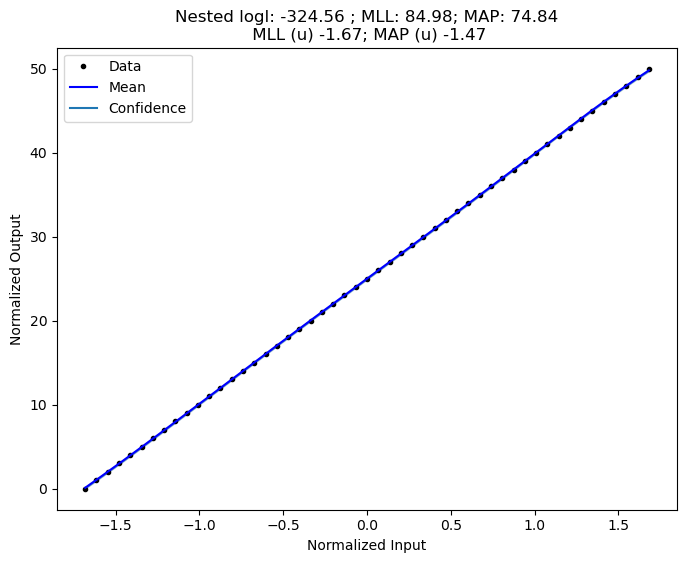

In [30]:
# Optimal GP according to Nested sampling
fixed_reinit(model, torch.tensor(best_hyperparameters))
model.eval()
likelihood.eval()
# mll of best parameterization according to Nested sampling:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
nested_top_mll = (mll(model(train_x), train_y))*len(train_x)
nested_top_map = nested_top_mll+log_normalized_prior(model)*len(train_x)
fig, ax = plot_model(model, likelihood, train_x, train_y, return_figure=True, loss_val=res.logl[best_idx], loss_type="Nested logl")
ax.title.set_text(f"{ax.title.get_text()} ; MLL: {nested_top_mll.item():.2f}; MAP: {nested_top_map.item():.2f}\n MLL (u) {-nested_top_mll/len(train_x):.2f}; MAP (u) {-nested_top_map/len(train_x):.2f}")

In [31]:
print(res.logz[best_idx])
res.logz[-1]

-332.53451720965575


-332.53451720965575

In [32]:
print(res.logl[best_idx])
res.logl[-1]

-324.5578308105469


-324.5578308105469

In [33]:
# Collect metric names and values into a list of tuples
metrics_data = [
    ("MLL", f"{unscaled_MLL.item():.3f}"),
    ("MLL (loss)", f"{mll_loss.item():.3f}"),
    ("AIC", f"{AIC_val.item():.3f}"),
    ("AIC (s)", f"{(AIC_val.item()*(-0.5)):.3f}"),
    ("BIC", f"{BIC_val.item():.3f}"),
    ("BIC (s)", f"{(BIC_val.item()*(-0.5)):.3f}"),
    

]
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [("MAP", f"{unscaled_MAP.item():.3f}"),
    ("MAP (loss)", f"{map_loss.item():.3f}"),
    ("AIC_M", f"{AIC_MAP_val.item():.3f}"),
    ("AIC_M (s)", f"{(AIC_MAP_val.item()*(-0.5)):.3f}"),
    ("BIC_M", f"{BIC_MAP_val.item():.3f}"),
    ("BIC_M (s)", f"{(BIC_MAP_val.item()*(-0.5)):.3f}"),
    ("Lap0", f"{Lap0_val.item():.3f}"),
    ("LapAIC", f"{LapAIC_val.item():.3f}"),
    ("LapBIC", f"{LapBIC_val.item():.3f}"),]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [    
    #("Nested (1)", f"{Nested_val_e1:.3f}"),
    ("Nested (3)", f"{Nested_val_e3:.3f}"),
    #("Nested (4)", f"{Nested_val_e4:.3f}"),
    #("Nested (5)", f"{Nested_val_e5:.3f}")
    ]
# Transpose the table: one row for the label, another for the value
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]

# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")

|        | MLL | MLL (loss) | AIC | AIC (s) | BIC | BIC (s) |
|--------|-----------|-----------|-----------|-----------|-----------|-----------|
| Value  | 116.616 | -2.287 | -227.232 | 113.616 | -221.436 | 110.718 |

|        | MAP | MAP (loss) | AIC_M | AIC_M (s) | BIC_M | BIC_M (s) | Lap0 | LapAIC | LapBIC |
|--------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| Value  | -16.442 | 0.322 | 38.884 | -19.442 | 44.679 | -22.340 | -18.407 | -20.407 | -22.340 |

|        | Nested (3) |
|--------|-----------|
| Value  | -332.535 |


In [34]:
print(f"Lap0/nested = {Lap0_val/Nested_val_e3:.3f}")
print(f"AIC (s)/nested = {AIC_val*(-0.5)/Nested_val_e3:.3f}") 

Lap0/nested = 0.055
AIC (s)/nested = -0.342


In [35]:

fixed_reinit(model_MAP, torch.tensor(best_hyperparameters))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_MAP, model_MAP)
map_loss = -mll(model_MAP(train_x), train_y)-log_normalized_prior(model_MAP)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
Nested_Lap0_val, Nested_Lap0_logs = Laplace(model_MAP, unscaled_MAP, param_punish_term=0)
print(Nested_Lap0_val)
print(Nested_Lap0_logs)
print(f"nested Lap0/nested = {Nested_Lap0_val/Nested_val_e3:.3f}")

tensor(-337.5087, dtype=torch.float64, grad_fn=<AddBackward0>)
{'MAP': tensor(334.7013, grad_fn=<NegBackward0>), 'punish term': tensor(-2.8074, dtype=torch.float64), 'laplace without replacement': tensor(nan, dtype=torch.float64, grad_fn=<SubBackward0>), 'correction term': 0, 'num_replaced': tensor(1), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale'], 'Jacobian': (tensor([-9.0883], grad_fn=<AddBackward0>), tensor(-76.6392, grad_fn=<AddBackward0>), tensor([[49.8265]], grad_fn=<AddBackward0>)), 'parameter values': tensor([[-6.0940],
        [ 4.7982],
        [ 1.3719]]), 'corrected Hessian': tensor([[ 12.0791,   4.4204, -41.2184],
        [  4.4204,  30.7446,  -2.2797],
        [-41.2184,  -2.2797, 339.7188]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([  6.2832,  31.4096, 344.8497], dtype=torch.float64), 'original symmetrized Hessian': tensor([[ -4.5930,   7.2430, -43.2600],
        [  7.24

### Main loop

### Results visualization

In [36]:
# The big figure with rows for each dataset and columns for [Dataset, Posterior (MLL), Posterior (MAP), Nested plot]


## 2D data

### XYZ